In [1]:
%matplotlib inline
from obspy import read, UTCDateTime as UTC
from obspy.signal.cross_correlation import correlation_detector
import obspy
import io
import matplotlib.pyplot as plt
import helpers
import numpy as np
import pandas as pd

from obspy.signal import trigger
from obspy.signal import filter

from datetime import datetime

from multiprocessing import Pool
import glob

import tempmatch as tm

In [2]:
data = tm.digest_data('/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.138')
data += tm.digest_data('/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.02.GDH.2019.138')
data += tm.digest_data('/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.03.GDH.2019.138')
data += tm.digest_data('/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.04.GDH.2019.138')
data += tm.digest_data('/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.05.GDH.2019.138')
data += tm.digest_data('/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.06.GDH.2019.138')

data[3].data = data[3].data*-1

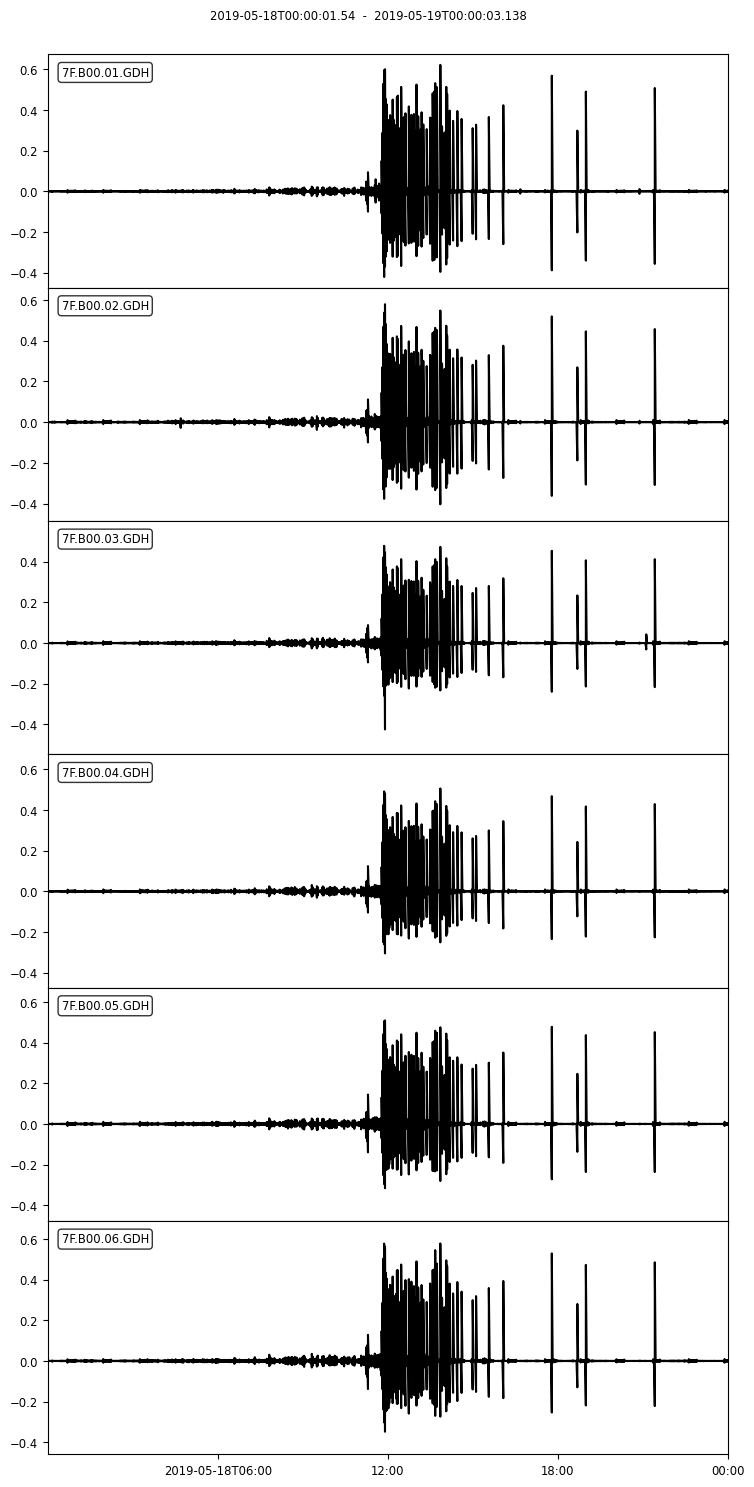

In [3]:
_ = data.plot()

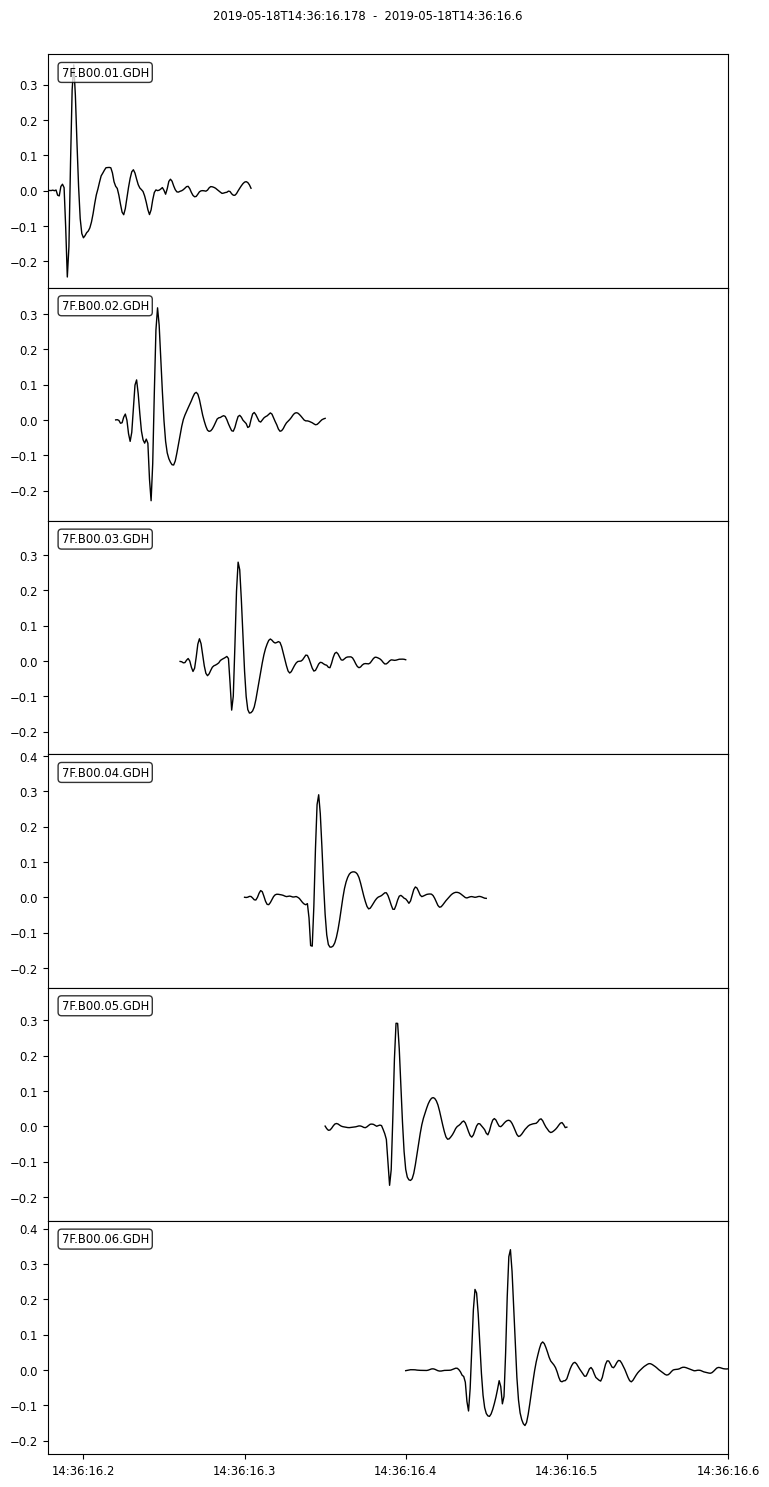

In [4]:
templates = data.select(id='7F.B00.01.GDH').slice(UTC('2019-05-18T14:36:16.178Z'), UTC('2019-05-18T14:36:16.304Z'))
templates += data.select(id='7F.B00.02.GDH').slice(UTC('2019-05-18T14:36:16.22Z'), UTC('2019-05-18T14:36:16.35Z'))
templates += data.select(id='7F.B00.03.GDH').slice(UTC('2019-05-18T14:36:16.26Z'), UTC('2019-05-18T14:36:16.4Z'))
templates += data.select(id='7F.B00.04.GDH').slice(UTC('2019-05-18T14:36:16.3Z'), UTC('2019-05-18T14:36:16.45Z'))
templates += data.select(id='7F.B00.05.GDH').slice(UTC('2019-05-18T14:36:16.35Z'), UTC('2019-05-18T14:36:16.50Z'))
templates += data.select(id='7F.B00.06.GDH').slice(UTC('2019-05-18T14:36:16.40Z'), UTC('2019-05-18T14:36:16.60Z'))

_ = templates.plot()

In [18]:
f = 100
gamma = np.mean([1.3, 1.67])
PA = 2.5 #bar
rho = 1

(2 * np.pi * f)**(-1) * ((3 * gamma * PA )/(rho))**(1/2)

0.0053114609167735968

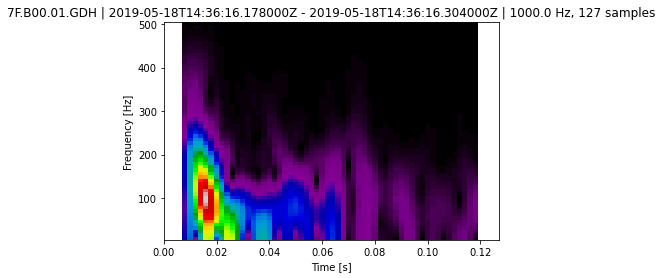

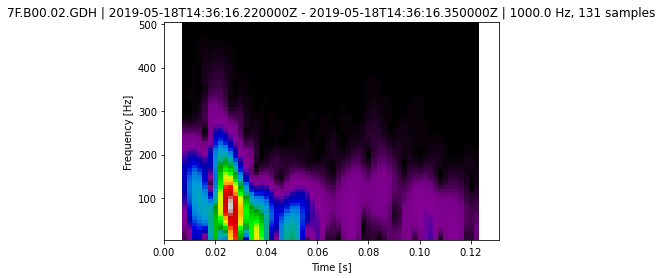

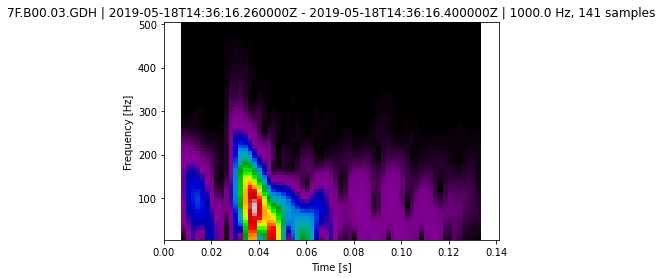

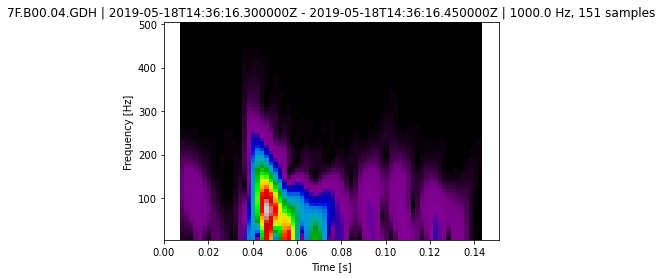

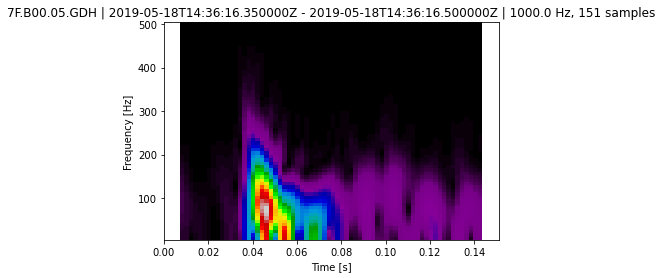

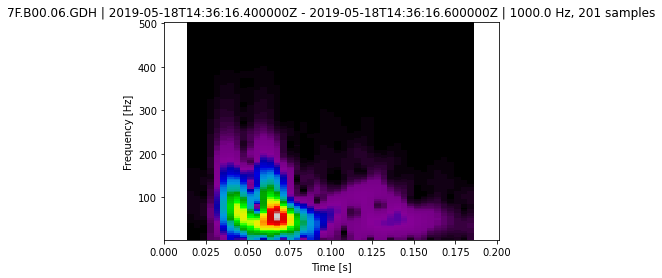

[None, None, None, None, None, None]

In [5]:
templates.spectrogram(cmap='nipy_spectral')

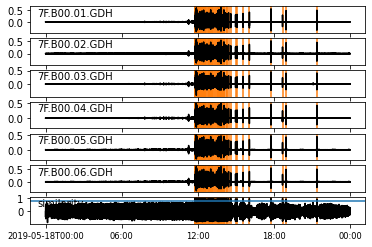

In [6]:
height = 0.8
distance = 1.1

detections, sims = correlation_detector(stream=data
                                       ,templates=templates
                                       ,heights=height
                                       ,distance=distance
                                       ,plot=data
                                       ,details=True)

In [7]:
# plt.hist(sims[0].data, bins=np.linspace(-1, 1, 201))
# plt.yscale('log')

In [8]:
df = pd.DataFrame(detections)
df['time'] = pd.to_datetime(df['time'].astype(str))
df.sort_values(by='time', inplace=True)
df['ones'] = 1
df.set_index('time', inplace=True)
df['cc_b00.01'] = df.cc_values.apply(lambda x: x['7F.B00.01.GDH'])
df['cc_b00.02'] = df.cc_values.apply(lambda x: x['7F.B00.02.GDH'])

In [9]:
df.head()

,similarity,cc_values,template_id,ones,cc_b00.01,cc_b00.02
time,,,,,,
2019-05-18 11:45:45.948000+00:00,0.948577,"{'7F.B00.01.GDH': 0.961882852154, '7F.B00.02.G...",0,1,0.961883,0.960447
2019-05-18 11:47:16.325000+00:00,0.962242,"{'7F.B00.01.GDH': 0.968174971844, '7F.B00.02.G...",0,1,0.968175,0.966407
2019-05-18 11:47:54.450000+00:00,0.964003,"{'7F.B00.01.GDH': 0.957940504348, '7F.B00.02.G...",0,1,0.957941,0.968231
2019-05-18 11:49:19.032000+00:00,0.979855,"{'7F.B00.01.GDH': 0.978991776853, '7F.B00.02.G...",0,1,0.978992,0.981711
2019-05-18 11:49:27.501000+00:00,0.966423,"{'7F.B00.01.GDH': 0.972505688606, '7F.B00.02.G...",0,1,0.972506,0.969615


<AxesSubplot:xlabel='time'>

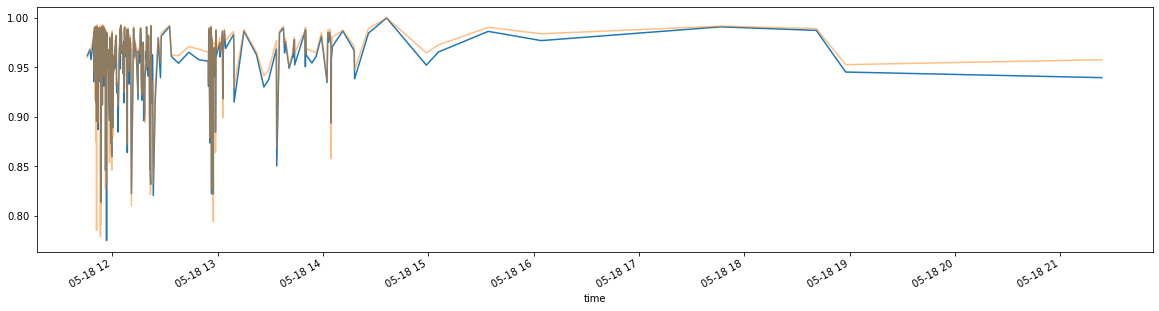

In [10]:
df['cc_b00.01'].plot(figsize=(20,5))
df['cc_b00.02'].plot(alpha=0.5)

In [11]:
df.cc_values[0]

{'7F.B00.01.GDH': 0.96188285215390723,
 '7F.B00.02.GDH': 0.96044652284227017,
 '7F.B00.03.GDH': 0.95484910871149253,
 '7F.B00.04.GDH': 0.94599250888182551,
 '7F.B00.05.GDH': 0.9479123763043612,
 '7F.B00.06.GDH': 0.9203793838783384}

In [12]:
df.describe()

,similarity,template_id,ones,cc_b00.01,cc_b00.02
count,399.000000,399.0,399.0,399.000000,399.000000
mean,0.957734,0.0,1.0,0.958093,0.959736
std,0.038876,0.0,0.0,0.035545,0.039051
min,0.803905,0.0,1.0,0.775181,0.779001
25%,0.950748,0.0,1.0,0.949166,0.953698
50%,0.969499,0.0,1.0,0.967945,0.970849
75%,0.981786,0.0,1.0,0.981297,0.983112
max,1.000000,0.0,1.0,1.000000,1.000000


Text(0, 0.5, 'cumulative number of events')

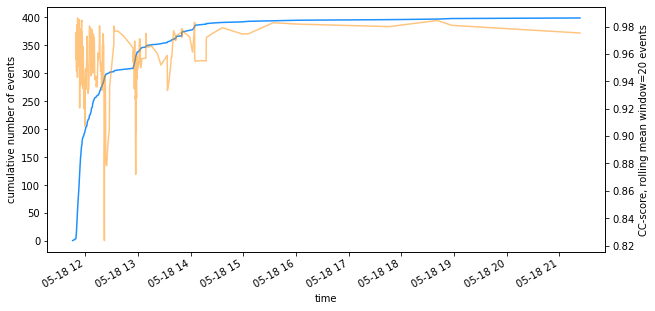

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
# df.cumsum()['ones'].plot(ax=ax, color='dodgerblue')
df['ones'].cumsum().plot(ax=ax, color='dodgerblue')

ax2 = ax.twinx()
df.similarity.rolling(window=5).mean().plot(ax=ax2, color='darkorange', alpha=0.5)
ax2.set_ylabel('CC-score, rolling mean window=20 events')
# ax.set_yscale('log')
ax.set_ylabel('cumulative number of events')
# ax.set_yscale('log')